In this project, we are simulating the growth of polymers using Monte Carlo methods. The first thing we do is import the used packages and initialise the matrices and parameters which we are going to use.

In [1]:
# Import everything

%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [7]:
#Initialize

Np = 1000 # number of polymers
Nb = 50 # number of beads
d = 1 # distance between the polymers
eps = 0.25 # constant for the Lennard Jones potential
sig = 0.8  # constant for the Lennard Jones potential
nang = 6 # number of different possible angles
kb = 1 
T = 1 # temperature
    
L = 2

aUp = 2.7 # constant for setting the upper limit
aLow = 1.5 # constant for setting the lower limit

ELJ = np.zeros((Np,Nb))
E = np.zeros((nang,1))
weight = np.zeros((nang,1))
PolWeight = np.ones((Np,Nb))
Weight3 = np.zeros((Np,1))

xpos = np.zeros((Np,Nb))
ypos = np.zeros((Np,Nb))
xpos[:,1] = 1 # first beat always at position (0,0) and second beat at (1,0)

Alive = np.zeros(Nb-1) 
Alive[0] = Np


After we initilialised everything, we define a function which adds a beat to every alive polymer.

In [8]:
def AddBeat(polnr,L):
    
    offset = np.random.uniform(0,1) # random offset so that the choice of angles is different every time
    
    for k in range(0,nang): # creating 6 different angles for placing the beats
        theta = offset + k*2*np.pi/nang 
        xpos[polnr,L] = xpos[polnr,L-1] + d*math.cos(theta) # new x-position
        ypos[polnr,L] = ypos[polnr,L-1] + d*math.sin(theta) # new y-position
        
        for j in range(0,L): # calculating the Lennard Jones potential for the beat positions
            xdist = xpos[polnr,L] - xpos[polnr,j]
            ydist = ypos[polnr,L] - ypos[polnr,j]
            r = np.sqrt(xdist**2 + ydist**2)
            ELJ[polnr,j] = 4*eps*((sig/r)**12-(sig/r)**6)
        
        E[k] = np.sum(ELJ[polnr])
        weight[k] = math.exp(-E[k]/(kb*T)) # calculate the weight for the beat position
        
    W = np.sum(weight)
    wInd = W/(0.75*nang)
    pick = np.random.uniform(0,1)
    w = 0
    
    for k in range(0,nang): # choose an angle with the roulette wheel algorithm
        w = w + weight[k]/W
        if w >= pick:
            theta = offset + k*2*np.pi/nang
            xpos[polnr,L] = xpos[polnr,L-1] + math.cos(theta)
            ypos[polnr,L] = ypos[polnr,L-1] + math.sin(theta)
            break

    return wInd

We have now defined a function for adding a beat to each alive polymer, so it is time to grow the polymers. We are using the PERM (pruned-enriched Rosenbluth method) algorithm, which removes the 'bad' polymers (polymers who's weight is below the lower limit) and enriches the 'good' polymers (polymers who's weight is above the upper limit), to make sure the population grows towards a balanced distribution. 

In [9]:
while (L < Nb): # the simulation runs untill we have reached the maximum polymer length
    
    for polnr in range(Np): # adding a beat to each polymer and calculate their weight
        W = AddBeat(polnr,L)
        PolWeight[polnr,L] = PolWeight[polnr,L-1]*W
        Weight3[polnr] = PolWeight[polnr,2]
        
    AvWeight = np.average(PolWeight[:,L])
    polnr = 0
    
    while (polnr < Np): # setting the upper and lower limit
        LowLim = aLow*AvWeight/Weight3[polnr]
        UpLim = aUp*AvWeight/Weight3[polnr]
        
        if PolWeight[polnr,L] < LowLim: # there is a 50% change of the polymer dying
            R = np.random.uniform(0,1)
            if R < 0.5: # the polymer survives
                PolWeight[polnr,L] = 2*PolWeight[polnr,L] # the weight is doubled
                polnr = polnr + 1
            else: # the polymer dies
                xpos = np.delete(xpos, polnr, axis=0)
                ypos = np.delete(ypos, polnr, axis=0)
                PolWeight = np.delete(PolWeight, polnr, axis=0)
                Weight3 = np.delete(Weight3, polnr, axis=0)
                Np = Np - 1
                               
        elif PolWeight[polnr,L] > UpLim: # the polymer will be cloned
            PolWeight[polnr,L] = 0.5*PolWeight[polnr,L] # the weight is halved
            xpos = np.append(xpos, [xpos[polnr,:]], axis=0) # the clone is added to the list
            ypos = np.append(ypos, [ypos[polnr,:]], axis=0)
            PolWeight = np.append(PolWeight, [PolWeight[polnr,:]], axis=0)
            polnr = polnr + 1
            
        else:
            polnr = polnr + 1
    
    # re-initiliase the matrices to accomodate the new situation
    
    ELJ = np.zeros((len(xpos),Nb))
    Weight3 = np.zeros((len(xpos),1))
    Np = len(xpos)
    Alive[L-1] = len(xpos) # check how many polymers are alive
    L = L + 1

C:\Users\niels\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in true_divide
C:\Users\niels\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: invalid value encountered in greater_equal


Now that we have grown the polymers, we can calculate the average of the end-to-end distance at each length. The end-to-end length scales with N as R ∝ N^0.75 in two dimensions, so our average of the end-to-end length squared should scale with N as R ∝ N^1.5. We will check this by fitting a curve to the data. 

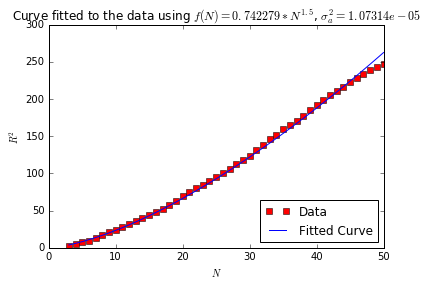

In [76]:
Rsq = np.average(xpos**2 + ypos**2, axis=0) # calculating the average of the end-to-end distance squared
N = np.linspace(3,Nb,(Nb-2))

def func(N, a): # defining a function to check the scaling
    return a*N**1.5

a, sigasq = curve_fit(func, N, Rsq[2:Nb]) # calculating the proportionallity constant a and the fit error

plt.title('Curve fitted to the data using $f(N) = %g * N^{1.5}$, $\sigma_a^2= %g$' %(a,sigasq))
plt.plot(N,Rsq[2:Nb],'rs', label="Data")
plt.plot(N,func(N, a), label="Fitted Curve")
plt.xlabel('$N$')
plt.ylabel('$R^2$')
plt.legend(loc='lower right')
plt.show()

To see how many polymers are alive at each growth step in the simulation, we plot the number of alive polymers against the number of beats. By changing the upper and lower limit, we can influence the population.

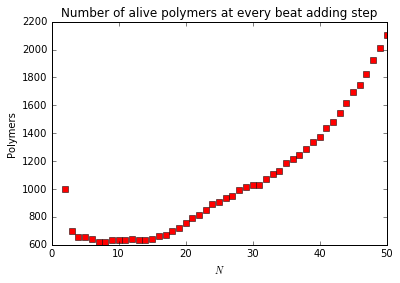

In [74]:
N = np.linspace(2,Nb,(Nb-1))

plt.title('Number of alive polymers at every beat adding step')
plt.plot(N,Alive,'rs')
plt.xlabel('$N$')
plt.ylabel('Polymers')
plt.show()